 # GCM Filters and Numerical Instability
 
The filtering scheme used in GCM Filters may become unstable and lead to wrong answers in case of filtering data over a wide range of scales. In this case, a combination of GCM filters and data coarsening would be more appropriate to maintain accuracy. 

For the purpose of demonstration, we employ output from a global MOM6 simulation having a spatial resolution of $1/4^{\circ}$ and perform a comnibation of spatial filtering and corsening to obtain desiered output.

In [1]:
import xarray as xr
import numpy as np
import gcm_filters
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
# Functions for plotting

def plot_map(ax, da, vmin=-999, vmax=999,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    cb.ax.tick_params(labelsize=12)

    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

### Filtering

We filter vorticity fileds to $2^{\circ}$ and $10^{\circ}$ resolutions. For this, we first create the filter objects for filtering by coarseing factors of 8 and 40. We then comapare the filtered data to the original data.

In [3]:
ds = xr.open_dataset("/archive/Hemant.Khatri/Tutorial_Data/Global_U_SSH.nc")

print(ds)

<xarray.Dataset>
Dimensions:       (xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
    time          object ...
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables: (12/30)
    ssu           (yh, xq) float32 ...
    ssv           (yq, xh) float32 ...
    zos           (yh, xh) float32 ...
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    ...            ...
    sftof         (yh, xh) float32 ...
    wet           (yh, xh) float32 ...
    wet_c         (yq, xq) float32 ...
    wet_u         (yh, xq) float32 ...
    wet_v         (yq, xh) float32 ...
    zeta          (yq, xq) float32 ...


In [6]:
# Filtering test

area = ds['areacello_bu']
wet_mast = ds['wet_c']

filter_2Deg = gcm_filters.Filter(filter_scale=8, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mast})

filter_10Deg = gcm_filters.Filter(filter_scale=40, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mast})

zeta_2Deg = filter_2Deg.apply(ds['zeta'] * area, dims=['yq', 'xq'])
%time zeta_2Deg = (zeta_2Deg/area).load()

zeta_10Deg = filter_10Deg.apply(ds['zeta'] * area, dims=['yq', 'xq'])
%time zeta_10Deg = (zeta_10Deg/area).load()

CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 23.1 ms
CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 23.1 ms


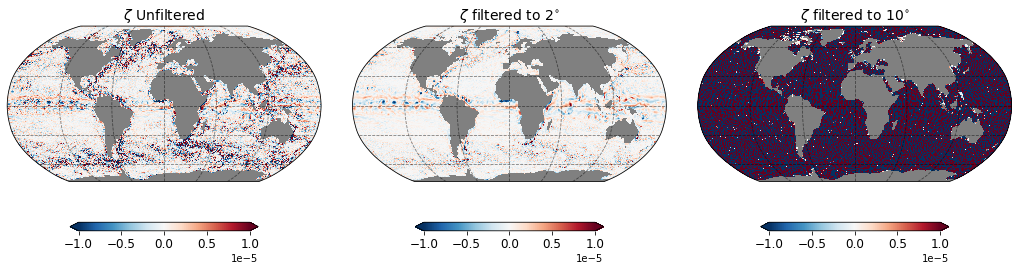

In [10]:
max_z = 1.e-5

grid1 = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,5])

tmp = ds['zeta'].assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ Unfiltered')

tmp = zeta_2Deg.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ filtered to $2^{\circ}$')

tmp = zeta_10Deg.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 2], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ filtered to $10^{\circ}$')

### Data Coarsening and Filtering 

From the figure above, numerical instability leads to large errors when an attempt is made to filter the data to $10^{\circ}$ resolution. In order to overcome this issue, we can first interpolate the data from $1/4^{\circ}$ to a coarser grid and then filter the coarsened data to $10^{\circ}$ resolution.

As shown below, we first coarsen the data by choosing every 4th gridpoint and then filter data to $10^{\circ}$ (this is only for demostration and, in practice, more advanced coarsening methods can be empoyed). With this approach, the numerical instability issue does not seem to appear anymore.

In [11]:
cor_fac = 4

zeta_coarse = zeta_2Deg.isel(xq=slice(0,ds.xq.shape[0],cor_fac), yq=slice(0,ds.yq.shape[0],cor_fac))

area = ds['areacello_bu'].isel(xq=slice(0,ds.xq.shape[0],cor_fac), yq=slice(0,ds.yq.shape[0],cor_fac))
wet_mast = ds['wet_c'].isel(xq=slice(0,ds.xq.shape[0],cor_fac), yq=slice(0,ds.yq.shape[0],cor_fac))

filter_cor = gcm_filters.Filter(filter_scale=10, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mast})

zeta_10Deg_cor = filter_cor.apply(zeta_coarse * area, dims=['yq', 'xq'])
%time zeta_10Deg_cor = (zeta_10Deg_cor/area).load()

CPU times: user 5.72 s, sys: 0 ns, total: 5.72 s
Wall time: 5.72 s


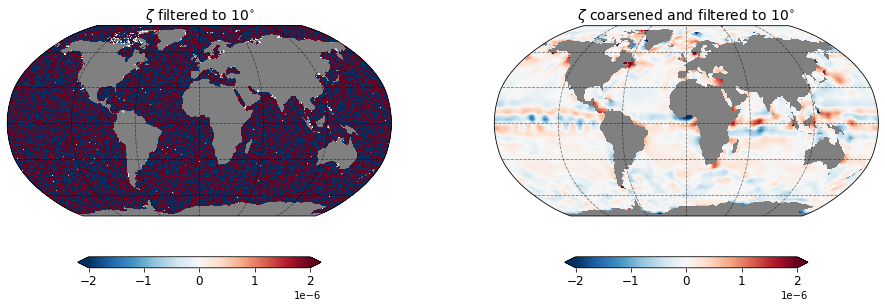

In [12]:
max_z = 0.2e-5

grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[16,5])

tmp = zeta_10Deg.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ filtered to $10^{\circ}$')

tmp = zeta_10Deg_cor.assign_coords({'geolat_c': ds['geolat_c'].isel(xq=slice(0,ds.xq.shape[0],4), yq=slice(0,ds.yq.shape[0],4)), 
                                    'geolon_c': ds['geolon_c'].isel(xq=slice(0,ds.xq.shape[0],4), yq=slice(0,ds.yq.shape[0],4))})
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ coarsened and filtered to $10^{\circ}$')